##  Notes from previous Experiments
From cross-validation experiments performed in "SGD and Neural Networks - MNIST" Notebook, 
the following parameters will be used:

1. Step_size = 0.75
2. lambda = 0.0001

In [1]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage
from sklearn import preprocessing

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
with open("Datasets\mnist.pkl",'rb') as mnist_file:
    train_data,valid_data,test_data = cPickle.load(mnist_file)

In [3]:
def smoothing(x,win_sz=30):
    smoothing_window = np.ones(win_sz)/win_sz
    smooth_func = np.convolve(x,smoothing_window)
    return smooth_func[:-win_sz]

2


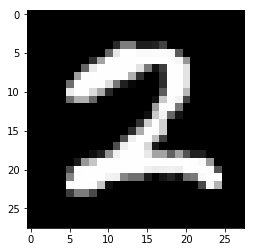

In [4]:
## In this block we are shuffling the data to avoid any classification bias
train_vec_in,train_label_out = train_data
permutation = np.random.permutation(train_vec_in.shape[0])
train_vec_in = train_vec_in[permutation,:]
train_reshape = np.reshape(train_vec_in,newshape=[50000,28,28])
train_label_out = train_label_out[permutation]

plt.imshow(train_reshape[3],cmap='gray')
print train_label_out[3]

In [5]:
valid_features,valid_labels = valid_data
test_features,test_labels = test_data

## Feature Visualization

In [24]:
features = train_vec_in
labels = train_label_out
epoch = 20
batch_sz = 100
step_size = 0.75
lamda = 0.0001
features_dim = np.shape(train_vec_in)
num_batches = features_dim[0]/batch_sz
classes = set(labels)
coeffs = 0.01 * np.random.randn(features_dim[1],len(classes))/(np.sqrt(features_dim[1]))    
train_accuracy, valid_accuracy = [],[]
    
for _ in xrange(1):
    for i in xrange(num_batches):
        batch_features = features[i*batch_sz:(i+1)*batch_sz]
        batch_dim = np.shape(batch_features)
        batch_labels = labels[i*batch_sz:(i+1)*batch_sz]
        batch_labels_dim = np.shape(batch_labels)
        
        scores = np.transpose(np.dot(batch_features,coeffs)) # KxN - for the \
                                                    # convenience of finding the max value for each input
        max_val = np.max(scores,axis=0) # 1xN
        exp_scores = np.exp(scores-max_val)
        probs = np.transpose(exp_scores/(np.sum(exp_scores,axis=0,keepdims=True))) # NxK
        probs[range(batch_dim[0]),batch_labels] -= 1
        probs /= batch_dim[0]
            
        dcoeff = np.dot(batch_features.T,probs)
        coeffs += -step_size*(dcoeff + lamda*coeffs)


## Batch Normalization
In this section we'll normalize the batch-input to obtain features with zero mean & unit variance, followed by 
affine transformation to obtain a scaled input distribution. 


In [20]:
''' DEFINED ARCHITECTURE 
       _ _ _  _ _       _ _ _ _ _       _ _ _ _       _ _ _       _ _ _  _ _       _ _ _ _
      |     ||   |     |         |     |       |     |     |     |     ||   |     |       |
----->| *W1 ||+B1|---->|normalize|---->| batch-|---->| reLU|---->| *W2 ||+B2|---->|softmax|----> LOSS
      |     ||   |     |         |     | norm  |     |     |     |     ||   |     |       |
      |_ _ _||_ _|     |_ _ _ _ _|     |_ _ _ _|     |_ _ _|     |_ _ _||_ _|     |_ _ _ _|
MxD     DxH        MxH             MxH           MxH         MxH   HxK        MxK
'''
def deep_batchnorm(features,labels,valid_features,valid_labels,step_size,lamda,batch_size=50,epoch=10,hidden_sz=100):

    features_dim= np.shape(features)
    classes = set(labels)
    coeff_1 = 0.01 * np.random.randn(features_dim[1],hidden_sz)/(np.sqrt(features_dim[1]))
    coeff_2 = 0.01 * np.random.randn(hidden_sz,len(classes))/(np.sqrt(hidden_sz))

    tot_cost,train_accuracy,valid_accuracy = [],[],[]
    coeff1_dim = np.shape(coeff_1)    
    coeff2_dim = np.shape(coeff_2)
    bias_1 = 0.01 * np.random.randn(1,coeff1_dim[1])
    bias_2 = 0.01 * np.random.randn(1,coeff2_dim[1])
    epsilon = 1e-7
    model = {}

    gamma = np.ones((hidden_sz,))
    beta = np.zeros((hidden_sz,))
    epsilon = 1e-7
    running_average = np.zeros((1,hidden_sz))
    running_std = np.zeros((1,hidden_sz))    
    train_accuracy,valid_accuracy = [],[]
    num_batches = features_dim[0]/batch_size
    
    for j in xrange(epoch):        
        for i in xrange(num_batches):
            batch_features = features[i*batch_size:(i+1)*batch_size]
            batch_dim = np.shape(batch_features)
            batch_labels = labels[i*batch_size:(i+1)*batch_size]
            batch_labels_dim = np.shape(batch_labels)
            
            #### Layer - 1 ####
            layer_1 = np.dot(batch_features,coeff_1) + bias_1
            
            mean_l1 = np.mean(layer_1,axis=0,keepdims=True) # hidden_szx1
            std_l1 = np.std(layer_1,axis=0,keepdims=True) # hidden_szx1
            running_average += mean_l1/num_batches
            running_std += std_l1**2/(num_batches-1)
            
            layer_1_norm = (layer_1 - mean_l1)/np.sqrt(std_l1**2 + epsilon)
            layer_1_batchnorm = gamma*layer_1_norm + beta
            reLU= np.maximum(0,layer_1_batchnorm)
            
            ## with max-equalization ##
            l2_scores = np.transpose(np.dot(reLU,coeff_2) + bias_2) # [KxN]
            l2_scores_max = np.max(l2_scores,axis=0) # [1xN]
            exp_scores = np.exp(l2_scores-l2_scores_max)
            probs_scores = exp_scores/np.sum(exp_scores,axis=0,keepdims=True)  # probs - shape(KxN)
            
            ## Loss computation
            tot_cost.append(-np.sum(probs_scores[batch_labels,range(batch_dim[0])])/batch_dim[0])
        
            ## backpropagation
            probs = np.transpose(probs_scores) # shape - NxK
            probs[range(batch_dim[0]),batch_labels] -= 1
            probs /= batch_dim[0]

            dcoeff_2 = np.dot(reLU.T,probs)   # dcoeff_2 - shape(hxK)
            dbias_2 = np.sum(probs, axis=0, keepdims=True)
            dhidden_layer = np.dot(probs,coeff_2.T)   # dhidden - shape(Nxh)
            dhidden_layer[reLU <= 0] = 0
            
            dlayer_1_batchnorm = gamma*dhidden_layer
            dgamma = np.sum(dhidden_layer*layer_1_norm,axis=0)
            dbeta = np.sum(dhidden_layer*1,axis=0)
            
            dstd_squared = np.sum(dlayer_1_batchnorm*mean_l1,axis=0)*(-1/2)*((std_l1**2 + epsilon)**(-1.5))
            dmean = np.sum(dlayer_1_batchnorm,axis=0)*(-(std_l1**2 + epsilon)**-1) + \
                                    dstd_squared*np.sum(-2*mean_l1,axis=0)/batch_size
            dlayer_1_norm = dlayer_1_batchnorm*((std_l1**2 + epsilon)**0.5) + dstd_squared*mean_l1 + dmean/batch_size
            
            ## This is pen-and-paper calculated dlayer_1_norm
            #dlayer_1_norm = dlayer_1_batchnorm*(((1-1/batch_size)/std_l1) + (mean_l1/std_l1**2)*(-2/batch_size)*layer_1_norm)
            
            dcoeff_1 = np.dot(batch_features.T,dlayer_1_norm)
            dbias_1 = np.sum(dlayer_1_norm, axis=0, keepdims=True)
            
            coeff_2 += -step_size*(dcoeff_2 + lamda*coeff_2)  # coeff_2 - shape(hxK)
            coeff_1 += -step_size*(dcoeff_1 + lamda*coeff_1)  # coeff_1 - shape(Dxh)
            bias_1 += -step_size * dbias_1
            bias_2 += -step_size * dbias_2
            gamma += -step_size * dgamma
            beta += -step_size * dbeta
            
            # Computing accuracy over training accuracy every iteration 
            # This can be commented as it slows down the training
            layer_1_train = np.dot(features,coeff_1)+bias_1
            layer_1_train_norm = (gamma*(layer_1_train-running_average)/np.sqrt(running_std**2 + 1e-7))+beta
            hidden_layer_train = np.maximum(0,layer_1_train_norm)
            scores_train = np.dot(hidden_layer_train,coeff_2)+bias_2
            predicted_class_train = np.argmax(scores_train, axis=1)
            train_accuracy.append(np.mean(predicted_class_train == labels))
    
    model['coeffs_l1'] = coeff_1
    model['bias_l1'] = bias_1
    model['coeffs_l2'] = coeff_2
    model['bias_l2'] = bias_2 
    model['train_accuracy'] = train_accuracy
    model['valid_accuracy'] = valid_accuracy
    model['tot_cost'] = tot_cost
    model['gamma'] = gamma
    model['beta'] = beta
    model['running_mean'] = running_average
    model['running_std'] = running_std
        
    return model

In [21]:
model_deep_batchnorm = deep_batchnorm(train_vec_in,train_label_out, \
                                                valid_features,valid_labels,batch_size=50, \
                                           epoch=10,hidden_sz=100,lamda=0.001,step_size=1.0)

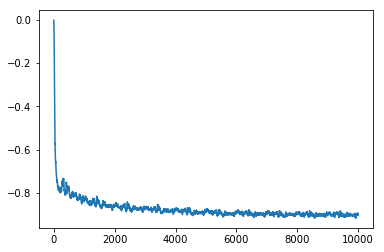

In [22]:
plt.plot(smoothing(model_deep_batchnorm['tot_cost']))
plt.show()